# Project: Identify Customer Segments

The project was identifying characteristics of customers of a mail-order sales company in Germany, applying unsupervised learning, so that the identified customer groups can be the direct target of the company's marketing. Here I used several steps. First step was cleaning the data set with missing value treatment, recoding to handle categorical and some mixed type data, and feature scaling. Then run PCA to reduce the dimensionality. By investigating each principal component, I found that each component is capturing important and different aspects of groups.  First PCA was financial aspect of the groups, second PCA captured generation (age) driven aspects, and third PCA captured gender driven characteristics of a group. Then K-mean clusters was implemented to define each cluster. 20 clusters was identified. By comparing portion of customer group and general population group in each cluster, characteristics of customers are identified, applying the characteristics of the clusters having most portion of customer groups. The important characteristics of the customer groups found were family minded customers with cultural incentives and financially interested groups. 

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.

azdias=pd.read_csv('Udacity_AZDIAS_Subset.csv', dtype={'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015': object}\
                   , sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
print(azdias.describe())
print(feat_info.describe())

            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

In [5]:
print(azdias.head())
print(feat_info.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
#create column 'missing_or_unknown_ls' with lists of floats and charater Xs
#NaN is float type, so when a value is converted to NaN, the entire column becomes float containing dot,
#and can't match with string type of missing or unknown variables.
feat_info['missing_or_unknown_ls']=feat_info['missing_or_unknown'].str[1:-1].str.split(',')
for i, v in enumerate(feat_info['missing_or_unknown_ls']):
    for s_i, s_v in enumerate(v):
        if s_v and (s_v.lstrip('+-').replace('.','',1).isdigit()):
            
            feat_info['missing_or_unknown_ls'][i][s_i]=float(s_v)
            
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_ls
0,AGER_TYP,person,categorical,"[-1,0]","[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1.0, 0.0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0.0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1.0]


In [7]:
#columns with type (object)
print(feat_info[(feat_info.attribute == 'AGER_TYP') |\
         (feat_info.attribute == 'OST_WEST_KZ') |\
         (feat_info.attribute == 'CAMEO_DEUG_2015')|\
         (feat_info.attribute == 'CAMEO_DEU_2015')| \
         (feat_info.attribute == 'CAMEO_INTL_2015')|\
         (feat_info.attribute == 'GFK_URLAUBERTYP')])

          attribute information_level         type missing_or_unknown  \
0          AGER_TYP            person  categorical             [-1,0]   
12  GFK_URLAUBERTYP            person  categorical                 []   
55      OST_WEST_KZ          building  categorical               [-1]   
57  CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]   
58   CAMEO_DEU_2015     microcell_rr4  categorical               [XX]   
59  CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]   

   missing_or_unknown_ls  
0            [-1.0, 0.0]  
12                    []  
55                [-1.0]  
57             [-1.0, X]  
58                  [XX]  
59            [-1.0, XX]  


In [8]:
#Unique values for object variables and some other variables
#'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'
print(azdias['AGER_TYP'].unique())
print(azdias['ALTERSKATEGORIE_GROB'].unique())
print(azdias['OST_WEST_KZ'].unique())
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_DEU_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())
print(azdias['ANREDE_KZ'].unique())

[-1  2  3  0  1]
[2 1 3 4 9]
[nan 'W' 'O']
[nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']
[1 2]


In [9]:
#list with object variables in azdias
azdias_categ_ls=azdias.columns[azdias.dtypes==object]

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

for col in azdias.columns:
    for var in feat_info['attribute']:
        if col == var:
          if feat_info[feat_info['attribute']==col]['missing_or_unknown_ls'].tolist()[0] != ['']:
            #print(feat_info[feat_info['attribute']==col]['missing_or_unknown_ls'].tolist()[0])
            for mis in feat_info[feat_info['attribute']==col]['missing_or_unknown_ls'].tolist()[0]: # mis is missing values in feat_info
              
                if col in azdias_categ_ls:
                    #print(col,'cate')
                    
                    azdias_nonan_dig=azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())] #Create separate vertor for digit and str
                    azdias_nonan_str=azdias[col][~((azdias[col].isnull())|(azdias[col].str.isdigit()))]
                    #print(azdias_nonan_str)
                    if (type(mis)!=str) and np.any(azdias_nonan_dig): # if mis is digit and digit exist in array
                        azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())][azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())].apply(float)==mis] = np.nan
                        
                        #print(mis,azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())][azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())].apply(float)==mis])
                    elif (type(mis)==str) and np.any(azdias_nonan_str):  # if mis is string and string exist in array
                        
                        azdias[col] =azdias[col].replace({mis: np.nan})
                        #print(mis,azdias[col][~((azdias[col].isnull())|(azdias[col].str.isdigit()))][azdias[col][~((azdias[col].isnull())|(azdias[col].str.isdigit()))]==mis])
                                            
                else:
                    #print(col,mis)
                    azdias[col][azdias[col].apply(float)==mis] = np.nan
                    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#confirming missing value treatment
print(azdias['AGER_TYP'].unique())
print(azdias['ALTERSKATEGORIE_GROB'].unique())
print(azdias['OST_WEST_KZ'].unique())
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_DEU_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())
print(azdias['ANREDE_KZ'].unique())

[ nan   2.   3.   1.]
[  2.   1.   3.   4.  nan]
[nan 'W' 'O']
[nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
[1 2]


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Define dictionary in each column how much fraction is missing value.
mis_frac_dic={}
for col in  azdias.columns:
    counts=pd.value_counts(azdias[col],dropna=False)
    
    for k in range(len(counts.index)):     
        if type(counts.index[k])!=str and (np.isnan(counts.index[k])):      
                frac=counts.values[k]/sum(counts.values)
    mis_frac_dic[col]=frac

mis_frac_dic 

{'AGER_TYP': 0.76955435296071339,
 'ALTERSKATEGORIE_GROB': 0.0032326437550282143,
 'ANREDE_KZ': 0.0032326437550282143,
 'CJT_GESAMTTYP': 0.0054464605299920001,
 'FINANZ_MINIMALIST': 0.0054464605299920001,
 'FINANZ_SPARER': 0.0054464605299920001,
 'FINANZ_VORSORGER': 0.0054464605299920001,
 'FINANZ_ANLEGER': 0.0054464605299920001,
 'FINANZ_UNAUFFAELLIGER': 0.0054464605299920001,
 'FINANZ_HAUSBAUER': 0.0054464605299920001,
 'FINANZTYP': 0.0054464605299920001,
 'GEBURTSJAHR': 0.44020282286885071,
 'GFK_URLAUBERTYP': 0.0054464605299920001,
 'GREEN_AVANTGARDE': 0.0054464605299920001,
 'HEALTH_TYP': 0.12476815514894735,
 'LP_LEBENSPHASE_FEIN': 0.10954858559212585,
 'LP_LEBENSPHASE_GROB': 0.10611509378706292,
 'LP_FAMILIE_FEIN': 0.087286991666489011,
 'LP_FAMILIE_GROB': 0.087286991666489011,
 'LP_STATUS_FEIN': 0.0054464605299920001,
 'LP_STATUS_GROB': 0.0054464605299920001,
 'NATIONALITAET_KZ': 0.12153551139391913,
 'PRAEGENDE_JUGENDJAHRE': 0.12136608091595687,
 'RETOURTYP_BK_S': 0.0054464605

(array([ 38.,  41.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([ 0.00323264,  0.10266702,  0.20210139,  0.30153576,  0.40097013,
         0.5004045 ,  0.59983887,  0.69927324,  0.79870762,  0.89814199,
         0.99757636]),
 <a list of 10 Patch objects>)

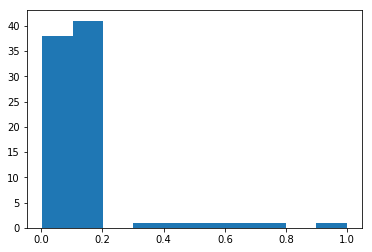

In [13]:
#Draw histogram to identify outliers
plt.hist(mis_frac_dic.values())


In [14]:
# Drop variables with missing portion is above 20%, since the frequency in the histogram is too small
small_mis_ls=[key for key, val in mis_frac_dic.items() if val <=0.2 ]
dropped_mis_ls=[key for key, val in mis_frac_dic.items() if val > 0.2 ]

print(dropped_mis_ls)
print('Number of features remaining after dropping variables with 20% more missing values:\n', len(small_mis_ls))


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Number of features remaining after dropping variables with 20% more missing values:
 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

---> My Discussion:

As seen in histogram in above cells, most of the missing fraction values are ranged between 0 to 20%, and the only small counts of variables are belong to large missing fraction values from 30 to 100%. Hence, variables with more than 20% of missing fraction values are dropped due to its outlier distributions. From the analysis, only 6 variables are belong to the outlier range, so those 6 variables are dropped.

Those six variables are specifically, 'AGER_TYP'(Best-ager typology), 'GEBURTSJAHR'(Year of birth), 'TITEL_KZ'(Academic title flag), 'ALTER_HH'(Birthdate of head of household), 'KK_KUNDENTYP'(Consumer pattern over past 12 months), 'KBA05_BAUMAX'(Most common building type within the microcell). Many of them are related to birthdate, and some educational background and census information of general populations, which may fall in privacy category and hard to get accurate information.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(891221, 79)
Missing data in each row is: 
 0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
dtype: int64


(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

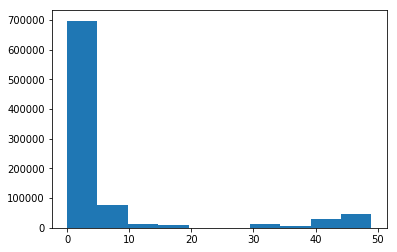

In [26]:
# investigate the distibution of number of missing values
azdias_1=azdias[small_mis_ls]
print(azdias_1.shape)
# How much data is missing in each row of the dataset?
print('Missing data in each row is: \n', azdias_1.isnull().sum(axis=1)[:20])
plt.hist(azdias_1.isnull().sum(axis=1))


(array([  6.28000000e+02,   2.56000000e+02,   8.80000000e+01,
          2.10000000e+01,   1.40070000e+04,   4.53300000e+03,
          6.35000000e+02,   2.77460000e+04,   6.49000000e+02,
          4.55810000e+04]),
 array([ 20. ,  22.9,  25.8,  28.7,  31.6,  34.5,  37.4,  40.3,  43.2,
         46.1,  49. ]),
 <a list of 10 Patch objects>)

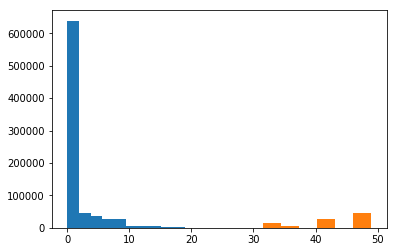

In [45]:
#Divide the data into two subsets: one for data points that are above 20 
#and a second subset for points below 20
#azdias_2a= azdias_1[azdias_1.isnull().sum(axis=1)<20]
#azdias_2b= azdias_1[azdias_1.isnull().sum(axis=1)>=20]
#plt.hist(azdias_2a.isnull().sum(axis=1))
#plt.hist(azdias_2b.isnull().sum(axis=1))

(array([  7.76340000e+04,   1.05580000e+04,   1.05960000e+04,
          1.80800000e+03,   3.15000000e+02,   5.00000000e+01,
          1.79180000e+04,   1.25700000e+03,   2.79010000e+04,
          4.60750000e+04]),
 array([  5. ,   9.4,  13.8,  18.2,  22.6,  27. ,  31.4,  35.8,  40.2,
         44.6,  49. ]),
 <a list of 10 Patch objects>)

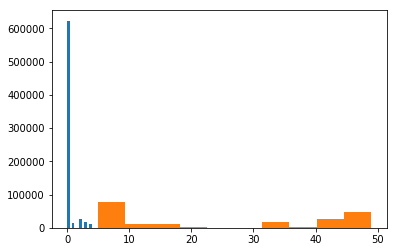

In [46]:
# Test with different threshold, 5
#azdias_2a= azdias_1[azdias_1.isnull().sum(axis=1)<5]
#azdias_2b= azdias_1[azdias_1.isnull().sum(axis=1)>=5]
#plt.hist(azdias_2a.isnull().sum(axis=1))
#plt.hist(azdias_2b.isnull().sum(axis=1))

(array([ 96415.,  60529.,  12134.,   5139.,    480.,    155.,  14016.,
          5031.,  28038.,  46075.]),
 array([  1. ,   5.8,  10.6,  15.4,  20.2,  25. ,  29.8,  34.6,  39.4,
         44.2,  49. ]),
 <a list of 10 Patch objects>)

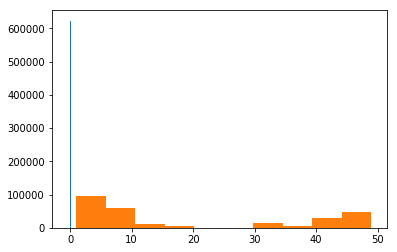

In [25]:
# Test with different threshold, 0
azdias_2a= azdias_1[azdias_1.isnull().sum(axis=1)==0]
azdias_2b= azdias_1[azdias_1.isnull().sum(axis=1)>0]
plt.hist(azdias_2a.isnull().sum(axis=1))
plt.hist(azdias_2b.isnull().sum(axis=1))

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold=0 # two data set with no missing vs. at least one missing
azdias_1['non_mis']=(azdias_1.isnull().sum(axis=1)==threshold).astype(int)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


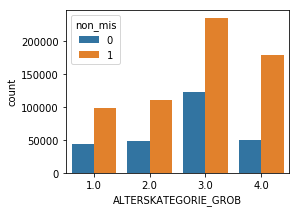

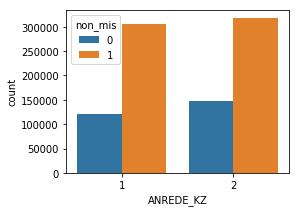

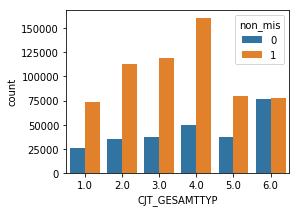

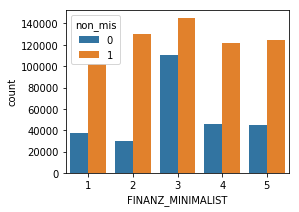

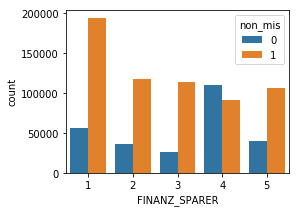

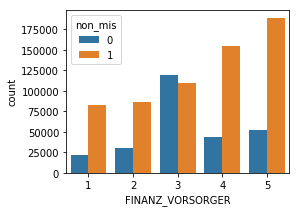

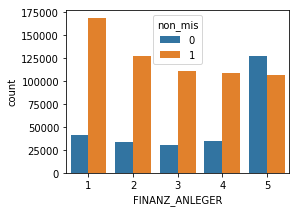

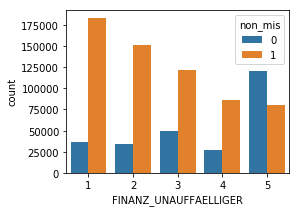

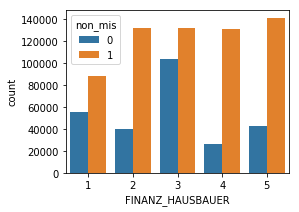

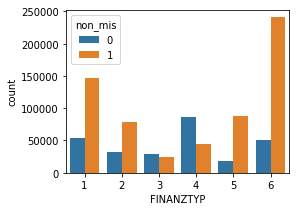

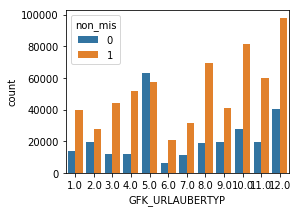

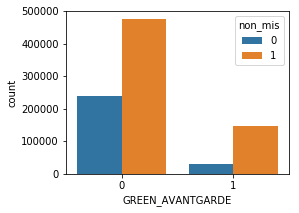

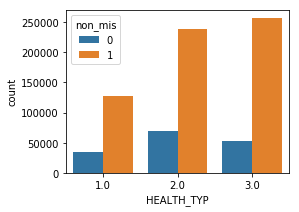

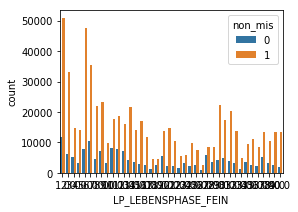

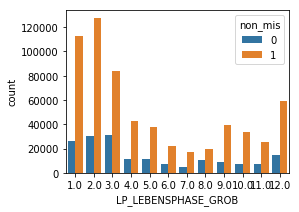

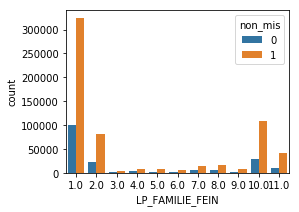

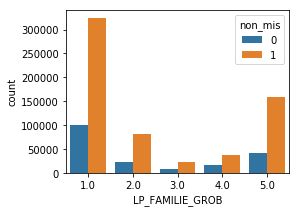

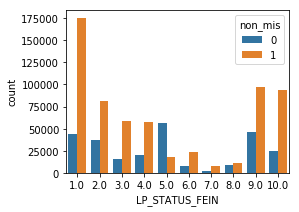

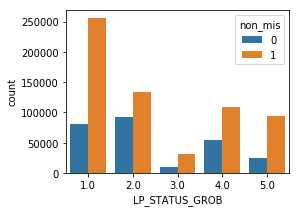

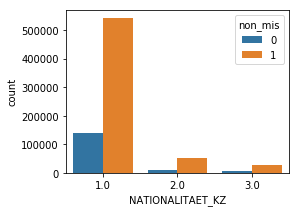

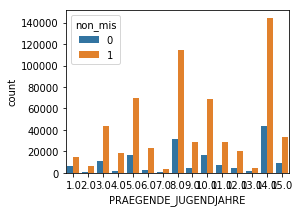

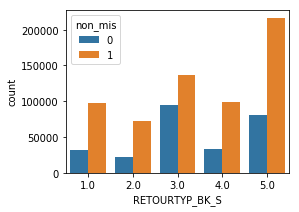

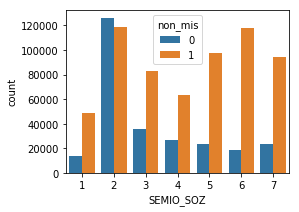

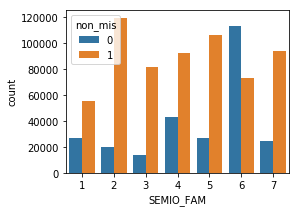

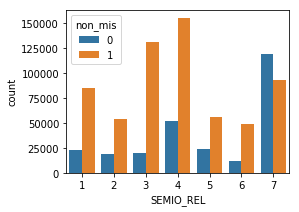

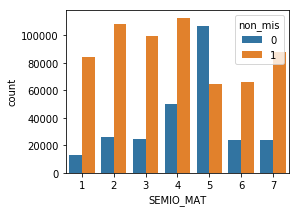

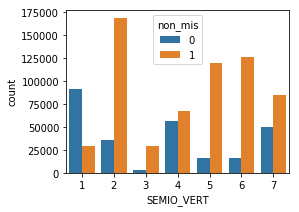

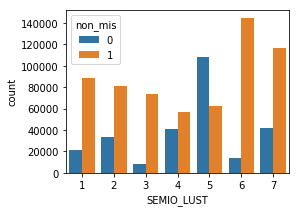

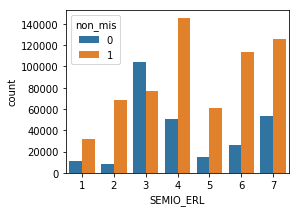

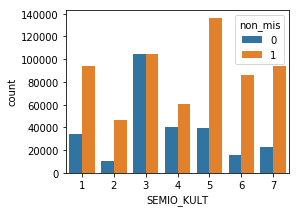

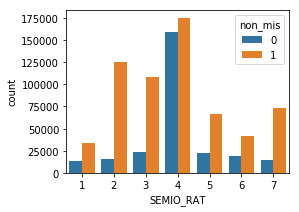

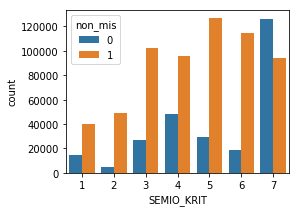

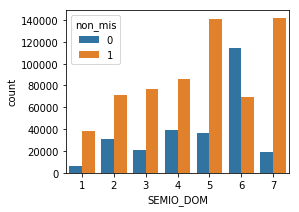

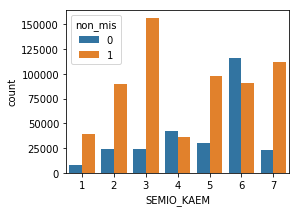

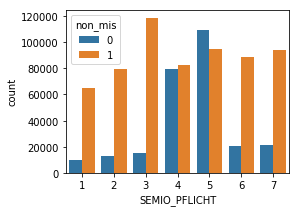

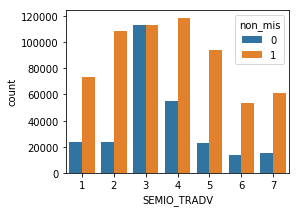

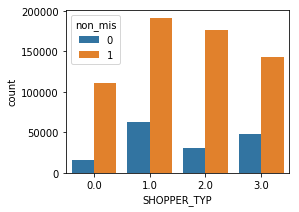

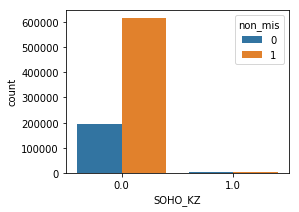

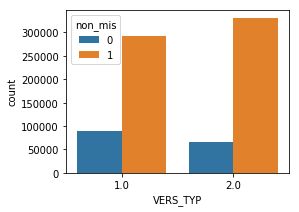

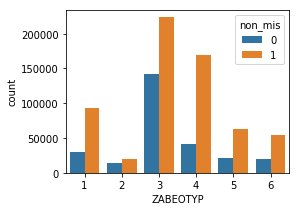

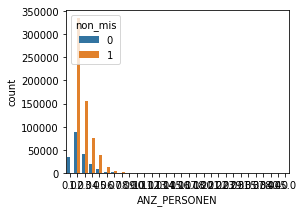

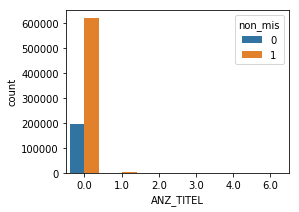

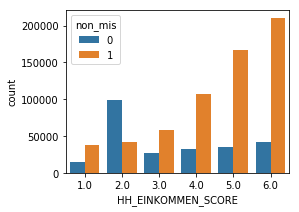

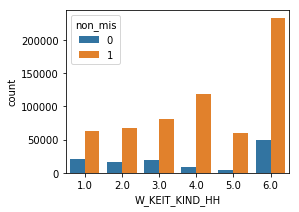

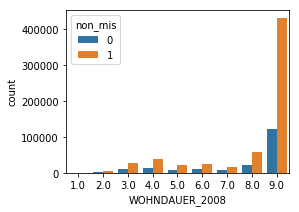

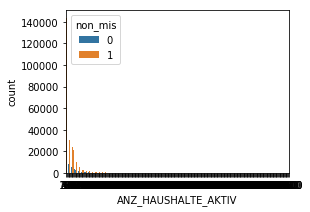

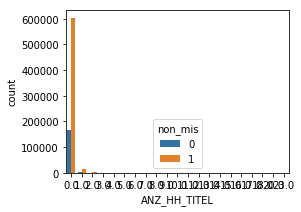

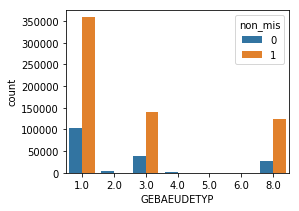

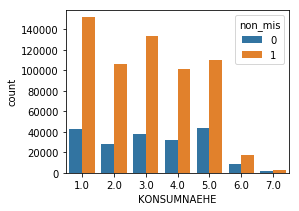

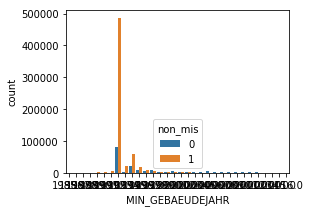

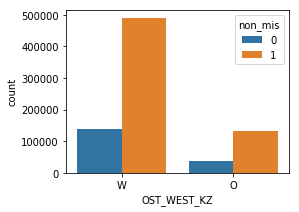

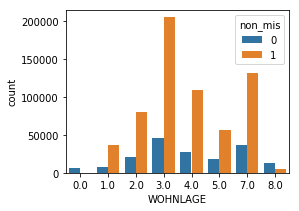

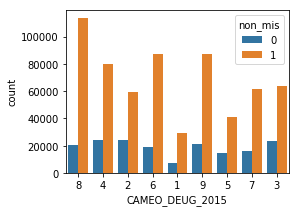

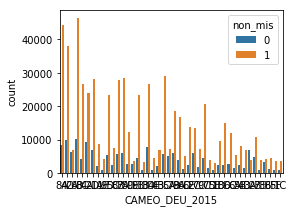

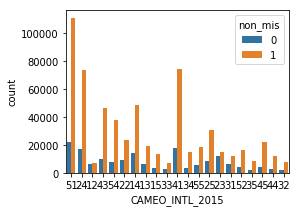

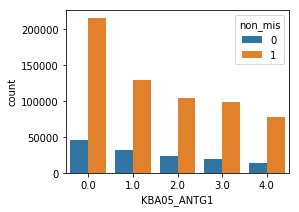

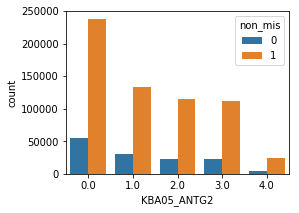

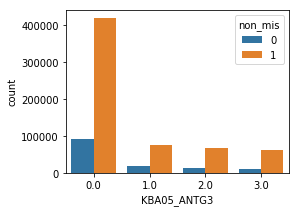

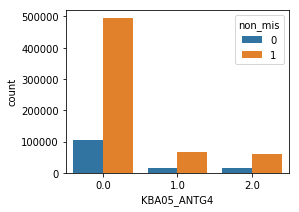

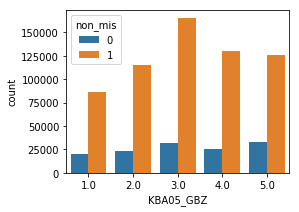

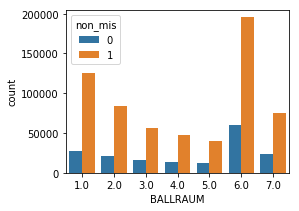

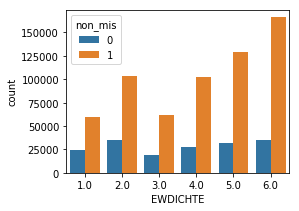

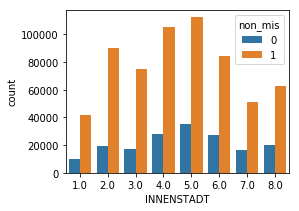

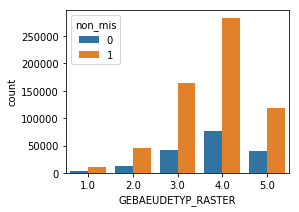

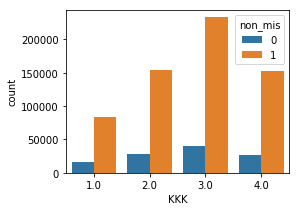

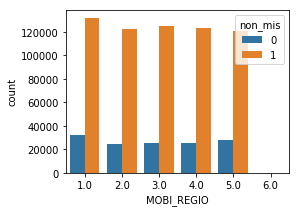

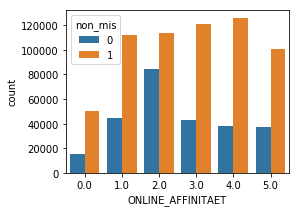

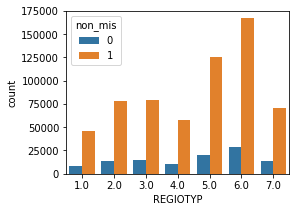

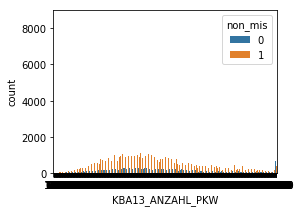

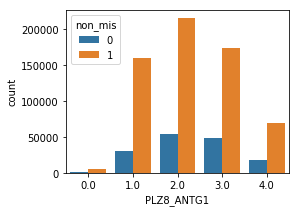

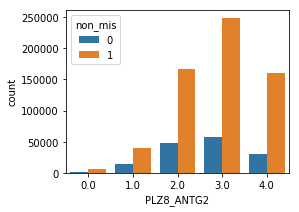

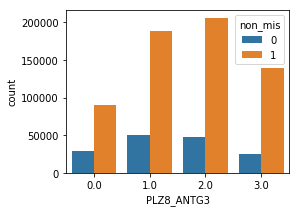

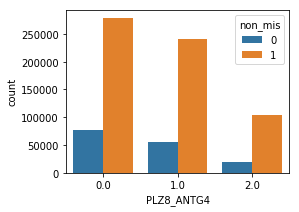

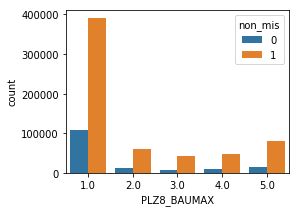

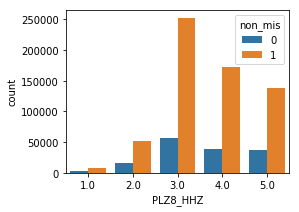

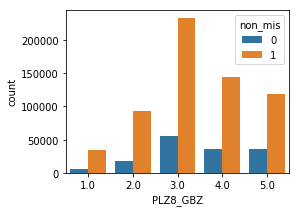

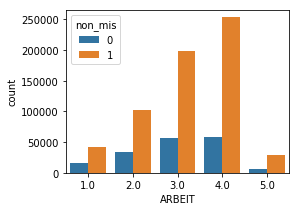

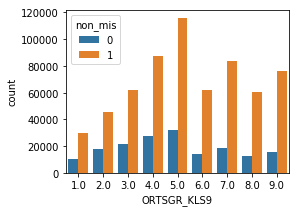

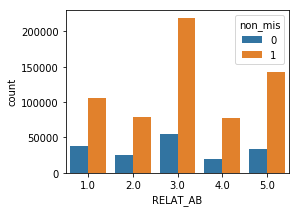

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#For all 69 variables compare the distributions
for col in small_mis_ls:
    fig,ax = plt.subplots(figsize=(4,3))
    ax = sns.countplot(x=col, hue="non_mis", data=azdias_1)



In [29]:
#As the direction above, create data set with only data point having no missing value.
azdias_1.drop('non_mis', axis=1, inplace=True)
azdias_2a= azdias_1[azdias_1.isnull().sum(axis=1)==0]
print(azdias_2a.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(623209, 79)


# Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

-->My Discussion

The threshold for diving two groups is selected as "zero", thus no missing vs. having missing values, since the frequency of zero missing value is much higher than the frequency of having 1 to 50 missing values, compared to threshold of 20 or 5, as shown in histograms in above cells.

In addition, for each 79 remaning columns, a countplot is generated comparing the distribution beween two data sets. In the count plots presentation in the above cell, there are some variables showing qualitatively different distibutions between two groups, such as:

 -Customer-Journey-Typology, CJT_GESAMTTYP, 

 -Financial typology such as FINANZ_MINIMALIST, FNANZ_SPARER, FINANZ_VORSORGER,   FINANZ_ANLEGER, FNANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER

 -Vacation habits, GFK_URLAUBERTYP, 

 -Personality typology such as SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_LUST, etc.

Those variables are related to finance related custromer characteristics and some detailed customer-specific personality. For those data having different distributions between the two groups may require special attention. But other variables are shown as having relatively similar distribution beween the two groups. Following the direction, the analysis is maintained using data set with only data point having no missing value. As a result, 623209 data points are kept for next analysis

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
feat_info.head()
print('categorical: %d features' %feat_info[feat_info.type=='categorical']['attribute'].count())
print('ordinal: %d features' %feat_info[feat_info.type=='ordinal']['attribute'].count())
print('mixed: %d features' %feat_info[feat_info.type=='mixed']['attribute'].count())

categorical: 21 features
ordinal: 49 features
mixed: 7 features


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cate_ls=[]
for col in feat_info[feat_info.type=='categorical']['attribute']:
    
    if col in azdias_2a.columns: 
        cate_ls.append(col)
        print(col, azdias_2a[col].unique()) # Print
        
         

ANREDE_KZ [2 1]
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6.]
FINANZTYP [1 5 2 4 6 3]
GFK_URLAUBERTYP [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [ 3.  1.  5.  2.  4.]
LP_STATUS_FEIN [  2.   3.   4.   1.  10.   9.   5.   6.   7.   8.]
LP_STATUS_GROB [ 1.  2.  5.  4.  3.]
NATIONALITAET_KZ [ 1.  2.  3.]
SHOPPER_TYP [ 3.  2.  0.  1.]
SOHO_KZ [ 1.  0.]
VERS_TYP [ 2.  1.]
ZABEOTYP [5 4 1 6 3 2]
GEBAEUDETYP [ 8.  1.  3.  5.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '6' '2' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B' '7A'
 '3D' '4E' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '5C' '9C' '7D' '5E' '1D' '8D'
 '6C' '5B' '7C' '4D' '3A' '2B' '7E' '4B' '2A' '3B' '6F' '5F' '1C' '6A']


In [32]:
#Drop repeated variables while detailed version of the variables are kept
print(cate_ls)
cate_ls.remove('LP_FAMILIE_GROB')
cate_ls.remove('LP_STATUS_GROB')
print(cate_ls)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.

print(azdias_2a.shape)#drop by missing fraction of 15% in each column
df_cate_to_dummy=pd.get_dummies(azdias_2a[cate_ls], columns=cate_ls)
print(df_cate_to_dummy.shape)#drop by no missing fraction in each row
azdias_3=pd.concat([azdias_2a,df_cate_to_dummy],axis=1)
print("After categrical variables are transfered to dummies, data set dimesion is: ", azdias_3.shape)
azdias_3.drop(cate_ls, axis=1, inplace=True)
print(len(cate_ls))
print("After original categrical variables are dropped, data set dimesion is: ",azdias_3.shape)

(623209, 79)
(623209, 125)
After categrical variables are transfered to dummies, data set dimesion is:  (623209, 204)
16
After original categrical variables are dropped, data set dimesion is:  (623209, 188)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

-->My Discussion:

Out of 18 categorical variables, LP_FAMILIE_GROB and LP_STATUS_GROB are dropped since these variables seem repeated, while its detailed versions of variables, LP_FAMILIE_FEIN and LP_STATUS_FEIN are kepted.
The remaining 16 categorical variables are transformed into dummy variables, whether it is binary or multi-level, to maintain consistentcy of data treatment, using one hot code. After original categorical variables are dropped, 623209 rows and 188 columns are kept in the data set.



# Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# all mixed variables are listed out of 79 variables
mix_ls=[]
for col in feat_info[feat_info.type=='mixed']['attribute']:
  
    if col in azdias_3.columns:
        mix_ls.append(col)
        print(col, azdias_3[col].unique())



LP_LEBENSPHASE_FEIN [ 21.   3.  32.   8.   2.   5.  10.   4.   6.  20.   1.  25.  18.  31.  38.
  30.   7.  22.  14.  35.  29.  24.  37.  12.  39.  36.  13.   9.  34.  26.
  33.  15.  11.  40.  16.  19.  23.  27.  28.  17.]
LP_LEBENSPHASE_GROB [  6.   1.  10.   2.   3.   5.   7.  12.   9.   4.  11.   8.]
PRAEGENDE_JUGENDJAHRE [ 14.  15.   8.   3.  10.  11.   9.   5.   4.   2.   6.   1.  12.  13.   7.]
WOHNLAGE [ 4.  2.  3.  7.  5.  1.  8.  0.]
CAMEO_INTL_2015 ['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '41' '25' '31' '52' '45'
 '35' '33' '44' '32' '23' '12']
PLZ8_BAUMAX [ 1.  2.  4.  5.  3.]


In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias_3['PRAEGENDE_JUGENDJAHRE'].unique())

def trans_gen(azdias):
  if np.isnan(azdias['PRAEGENDE_JUGENDJAHRE']):
    return np.nan

  else:
    if (azdias['PRAEGENDE_JUGENDJAHRE'] == 1.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 2.0 ) :
        return 40
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 3.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 4.0 ) :
        return 50
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 5.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 6.0 ) \
    or (azdias['PRAEGENDE_JUGENDJAHRE'] == 7.0 ):
        return 60
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 8.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 9.0 ) :
        return 70

    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 10.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 11.0 ) \
    or (azdias['PRAEGENDE_JUGENDJAHRE'] == 12.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 13.0 )  :
        return 80
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 14.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 15.0 ) :
        return 90



azdias_3['PRAEGENDE_JUGENDJAHRE_gen']= azdias_3.apply(trans_gen, axis=1)




[ 14.  15.   8.   3.  10.  11.   9.   5.   4.   2.   6.   1.  12.  13.   7.]


In [36]:
def trans_main(azdias):
  if np.isnan(azdias['PRAEGENDE_JUGENDJAHRE']):
    return np.nan

  else:
    if (azdias['PRAEGENDE_JUGENDJAHRE'] == 1.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 3.0 ) or \
    (azdias['PRAEGENDE_JUGENDJAHRE'] == 5.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 8.0 ) or \
    (azdias['PRAEGENDE_JUGENDJAHRE'] == 10.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 12.0 ) or \
    (azdias['PRAEGENDE_JUGENDJAHRE'] == 14.0 ) :
        return 1
    else:
        return 0
  

azdias_3['PRAEGENDE_JUGENDJAHRE_main']= azdias_3.apply(trans_main, axis=1)
print(azdias_3.shape)

(623209, 190)


In [37]:
#confirming trnasfermations
print(azdias_3[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_main','PRAEGENDE_JUGENDJAHRE_gen']][np.isnan(azdias_3['PRAEGENDE_JUGENDJAHRE'])][0:20])

print(azdias_3[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_main','PRAEGENDE_JUGENDJAHRE_gen']][azdias_3['PRAEGENDE_JUGENDJAHRE']==9.0][0:20])

Empty DataFrame
Columns: [PRAEGENDE_JUGENDJAHRE, PRAEGENDE_JUGENDJAHRE_main, PRAEGENDE_JUGENDJAHRE_gen]
Index: []
     PRAEGENDE_JUGENDJAHRE  PRAEGENDE_JUGENDJAHRE_main  \
19                     9.0                           0   
124                    9.0                           0   
172                    9.0                           0   
206                    9.0                           0   
218                    9.0                           0   
256                    9.0                           0   
268                    9.0                           0   
283                    9.0                           0   
299                    9.0                           0   
307                    9.0                           0   
329                    9.0                           0   
352                    9.0                           0   
394                    9.0                           0   
400                    9.0                           0   
431             

In [38]:
print(azdias_3['CAMEO_INTL_2015'].unique())
azdias_3['CAMEO_INTL_2015_wealth']=np.where(azdias_3['CAMEO_INTL_2015'].isnull(), np.nan, azdias_3['CAMEO_INTL_2015'].str[0] )
azdias_3['CAMEO_INTL_2015_status']=np.where(azdias_3['CAMEO_INTL_2015'].isnull(), np.nan, azdias_3['CAMEO_INTL_2015'].str[1] )
print(azdias_3.shape)

['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '41' '25' '31' '52' '45'
 '35' '33' '44' '32' '23' '12']
(623209, 192)


In [39]:
#confirming trnasfermations
print(azdias_3[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth','CAMEO_INTL_2015_status']][azdias_3['CAMEO_INTL_2015'].isnull()][0:20])
print(azdias_3[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth','CAMEO_INTL_2015_status']][azdias_3['CAMEO_INTL_2015']=='32'][0:20])

Empty DataFrame
Columns: [CAMEO_INTL_2015, CAMEO_INTL_2015_wealth, CAMEO_INTL_2015_status]
Index: []
     CAMEO_INTL_2015 CAMEO_INTL_2015_wealth CAMEO_INTL_2015_status
155               32                      3                      2
338               32                      3                      2
765               32                      3                      2
945               32                      3                      2
1060              32                      3                      2
1217              32                      3                      2
1412              32                      3                      2
1428              32                      3                      2
1433              32                      3                      2
1451              32                      3                      2
1516              32                      3                      2
1748              32                      3                      2
1751              32        

In [40]:
azdias_3.drop(mix_ls, axis=1, inplace=True)
print(azdias_3.shape)

(623209, 186)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Out of 6 mixed variables,two mixed variables, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 variables are decomposed by two dimensions following the guidance in the notebook.
Other mixed variables, LP_LEBENSPHASE_FEIN Life stage(Life stage, fine scale), LP_LEBENSPHASE_GROB(Life stage, rough scale), WOHNLAGE (Neighborhood quality), PLZ8_BAUMAX (Most common building type within the PLZ8 region) are simply dropped, since the variables seem repeated/correlated with/captured by/somewhat regional compared to other variables.
Since the entire variables considered in the data set are already 186 variables, it will be computationally difficult in clustering. After mixed variables are feature engineered, 623209 rows and 186 columns are kept in the data set.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# dropped mixed variables after engineered


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
#function for mixed 
def trans_gen(azdias):
  
  if np.isnan(azdias['PRAEGENDE_JUGENDJAHRE']):
    
    return np.nan

  else:
    if (azdias['PRAEGENDE_JUGENDJAHRE'] == 1.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 2.0 ) :
        return 40
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 3.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 4.0 ) :
        return 50
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 5.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 6.0 ) \
    or (azdias['PRAEGENDE_JUGENDJAHRE'] == 7.0 ):
        return 60
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 8.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 9.0 ) :
        return 70

    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 10.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 11.0 ) \
    or (azdias['PRAEGENDE_JUGENDJAHRE'] == 12.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 13.0 )  :
        return 80
    elif (azdias['PRAEGENDE_JUGENDJAHRE'] == 14.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 15.0 ) :
        return 90

#function for mixed 
def trans_main(azdias):
  if np.isnan(azdias['PRAEGENDE_JUGENDJAHRE']):
    return np.nan

  else:
    if (azdias['PRAEGENDE_JUGENDJAHRE'] == 1.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 3.0 ) or \
    (azdias['PRAEGENDE_JUGENDJAHRE'] == 5.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 8.0 ) or \
    (azdias['PRAEGENDE_JUGENDJAHRE'] == 10.0 ) or (azdias['PRAEGENDE_JUGENDJAHRE'] == 12.0 ) or \
    (azdias['PRAEGENDE_JUGENDJAHRE'] == 14.0 ) :
        return 1
    else:
        return 0
  


def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info['missing_or_unknown_ls']=feat_info['missing_or_unknown'].str[1:-1].str.split(',')
    for i, v in enumerate(feat_info['missing_or_unknown_ls']):
        for s_i, s_v in enumerate(v):
            if s_v and (s_v.lstrip('+-').replace('.','',1).isdigit()):

                feat_info['missing_or_unknown_ls'][i][s_i]=float(s_v)

    feat_info.head()
    
    azdias_categ_ls=azdias.columns[azdias.dtypes==object]
    
    for col in azdias.columns:
        for var in feat_info['attribute']:
            if col == var:
              if feat_info[feat_info['attribute']==col]['missing_or_unknown_ls'].tolist()[0] != ['']:
                #print(feat_info[feat_info['attribute']==col]['missing_or_unknown_ls'].tolist()[0])
                for mis in feat_info[feat_info['attribute']==col]['missing_or_unknown_ls'].tolist()[0]: # mis is missing values in feat_info

                    if col in azdias_categ_ls:
                        #print(col,'cate')

                        azdias_nonan_dig=azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())] #Create separate vertor for digit and str
                        azdias_nonan_str=azdias[col][~((azdias[col].isnull())|(azdias[col].str.isdigit()))]
                        #print(azdias_nonan_str)
                        if (type(mis)!=str) and np.any(azdias_nonan_dig): # if mis is digit and digit exist in array
                            azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())][azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())].apply(float)==mis] = np.nan

                            #print(mis,azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())][azdias[col][(~azdias[col].isnull())&(azdias[col].str.isdigit())].apply(float)==mis])
                        elif (type(mis)==str) and np.any(azdias_nonan_str):  # if mis is string and string exist in array

                            azdias[col] =azdias[col].replace({mis: np.nan})
                            #print(mis,azdias[col][~((azdias[col].isnull())|(azdias[col].str.isdigit()))][azdias[col][~((azdias[col].isnull())|(azdias[col].str.isdigit()))]==mis])

                    else:
                        #print(col,mis)
                        azdias[col][azdias[col].apply(float)==mis] = np.nan

    # remove selected columns and rows, ...
    # select the same columns as popultation for the same sklearn to be run using transform() 
    #mis_frac_dic={}
    #for col in  azdias.columns:
    #    counts=pd.value_counts(azdias[col],dropna=False)

    #    for k in range(len(counts.index)):     
    #        if type(counts.index[k])!=str and (np.isnan(counts.index[k])):      
    #                frac=counts.values[k]/sum(counts.values)
    #    mis_frac_dic[col]=frac
    #small_mis_ls=[key for key, val in mis_frac_dic.items() if val <0.3 ] 
    azdias_clean=azdias[small_mis_ls] # columns list from population data set
    #print(azdias_clean.shape)
    threshold=0 # two data set with no missing vs. at least one missing
    azdias_clean1=azdias_clean[azdias_clean.isnull().sum(axis=1)==0]
    #print(azdias_clean1.shape)
    # select, re-encode, and engineer column values.
    #categorical
    #cate_ls=[]
    #for col in feat_info[feat_info.type=='categorical']['attribute']:

    #    if col in azdias_clean1.columns: #if column missing value fraction is less than 10%.
    #        cate_ls.append(col)
            #print(col, azdias_clean1[col].unique()) # Print
    df_cate_to_dummy_c=pd.get_dummies(azdias_clean1[cate_ls], columns=cate_ls, dummy_na=True)
    df_cate_to_dummy_c1=df_cate_to_dummy_c.loc[:,df_cate_to_dummy.columns] #population list
    #print('df_cate_to_dummy',df_cate_to_dummy_c1.shape)
    azdias_cn_engineer=pd.concat([azdias_clean1,df_cate_to_dummy_c1],axis=1)
    #print('concate',azdias_cn_engineer.shape)
    azdias_cn_engineer.drop(cate_ls, axis=1, inplace=True) #population list
    #print('drop_prev_list',azdias_cn_engineer.shape)
    #mixed
    
    azdias_cn_engineer['PRAEGENDE_JUGENDJAHRE_gen']= azdias_cn_engineer.apply(trans_gen, axis=1)
    azdias_cn_engineer['PRAEGENDE_JUGENDJAHRE_main']= azdias_cn_engineer.apply(trans_main, axis=1)
    azdias_cn_engineer['CAMEO_INTL_2015_wealth']=np.where(azdias_cn_engineer['CAMEO_INTL_2015'].isnull(), np.nan, azdias_cn_engineer['CAMEO_INTL_2015'].str[0] )
    azdias_cn_engineer['CAMEO_INTL_2015_status']=np.where(azdias_cn_engineer['CAMEO_INTL_2015'].isnull(), np.nan, azdias_cn_engineer['CAMEO_INTL_2015'].str[1] )
    
    #mix_ls=[]
    #for col in feat_info[feat_info.type=='mixed']['attribute']:
  
    #  if col in azdias_cn_engineer.columns:
    #    mix_ls.append(col)
            #print(col, azdias_cn_engineer[col].unique())


    azdias_cn_engineer.drop(mix_ls, axis=1, inplace=True) #population list
    # Return the cleaned dataframe.
    #print(azdias_cn_engineer.shape)
    return azdias_cn_engineer
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#All NaN is dropped.
df=azdias_3
print(len(df.columns[df.isnull().sum()!=0]))
print(len(df.index[df.isnull().sum(axis=1)!=0]))

0
0


In [46]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled=scaler.fit_transform(df)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_scaled)
print(len(pca.explained_variance_ratio_)) 

186


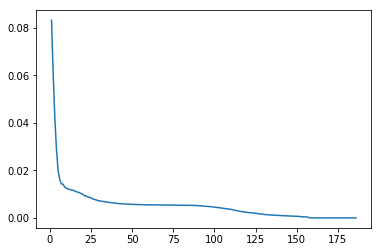

In [49]:
# Investigate the variance accounted for by each principal component.
import matplotlib.pyplot as plt
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)


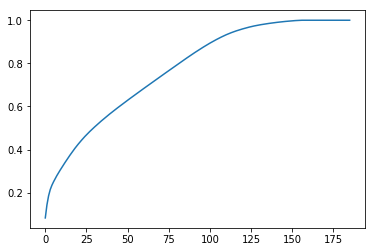

In [50]:
cumul_ratio=[]
sum_num=0
for i in pca.explained_variance_ratio_:
    sum_num+=i
    cumul_ratio.append(sum_num)
plt.plot(range(len(pca.explained_variance_ratio_)), cumul_ratio)



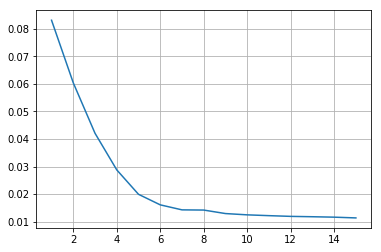

In [51]:
plt.plot(range(1,16), pca.explained_variance_ratio_[0:15])
plt.grid(True)

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=6)
df_scaled_pca=pca.fit_transform(df_scaled)
#plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)




### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

From the graph produced by explained_variance_ratio_, by elbow method, at principal component of 6, the explained_variance_ratio_ decreased rapidly. Those are capturing small portion of total variation. Since the purpose is clustering customer groups efficiently rather than capturing many variation in the PCA components, and also more PCAs will consume more computation times, first tried 6 PCAs to see if this is enought for clustering. If it is not, more compenents may need to be used.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def sorted_dict(i):
    """Print out i-th principal component sorted by weights"""

    dic_weight={}
    for j in range(len(pca.components_[i])):
        dic_weight[pca.components_[i][j]]=df.columns[j]
    dic_weight_sort= dict(sorted(dic_weight.items()))
    return dic_weight_sort

In [55]:
sorted_dict(0)

{-0.20579524910183838: 'LP_STATUS_GROB',
 -0.20187039668632897: 'MOBI_REGIO',
 -0.19643020882869736: 'FINANZ_MINIMALIST',
 -0.19128429619741397: 'KBA05_ANTG1',
 -0.17879461397069593: 'PLZ8_ANTG1',
 -0.17845021748102582: 'KBA05_GBZ',
 -0.13360343473389691: 'PLZ8_GBZ',
 -0.12974531082154234: 'LP_STATUS_FEIN_10.0',
 -0.12717520637963331: 'KONSUMNAEHE',
 -0.12052591006368982: 'GREEN_AVANTGARDE_1',
 -0.11935079495416433: 'INNENSTADT',
 -0.11419479220295116: 'CAMEO_INTL_2015_status',
 -0.10850503902738783: 'ALTERSKATEGORIE_GROB',
 -0.104454209571788: 'FINANZ_VORSORGER',
 -0.097609427351146832: 'LP_STATUS_FEIN_9.0',
 -0.093669462137140655: 'ZABEOTYP_1',
 -0.092277575627154232: 'GEBAEUDETYP_RASTER',
 -0.087633035441952556: 'BALLRAUM',
 -0.086917294986909199: 'CAMEO_DEUG_2015_2',
 -0.086529892925639118: 'GEBAEUDETYP_1.0',
 -0.08631729404051007: 'FINANZTYP_2',
 -0.082058636466664461: 'ANZ_PERSONEN',
 -0.080500321614967132: 'SEMIO_LUST',
 -0.077364705275246443: 'LP_FAMILIE_GROB',
 -0.071380090150

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_dict(1)

{-0.22667428006564219: 'PRAEGENDE_JUGENDJAHRE_gen',
 -0.22045416389281264: 'SEMIO_REL',
 -0.21118922134704474: 'FINANZ_SPARER',
 -0.20701977229961169: 'FINANZ_UNAUFFAELLIGER',
 -0.20579618544197459: 'SEMIO_PFLICHT',
 -0.2023210504189614: 'SEMIO_TRADV',
 -0.18657809132597153: 'FINANZ_ANLEGER',
 -0.17510030305126181: 'SEMIO_KULT',
 -0.16080265949822325: 'ONLINE_AFFINITAET',
 -0.15586030070107101: 'SEMIO_RAT',
 -0.13951399154125202: 'SEMIO_FAM',
 -0.12378682133671674: 'SEMIO_MAT',
 -0.11773891870015803: 'FINANZTYP_1',
 -0.1029072863039299: 'ZABEOTYP_4',
 -0.09068801154295876: 'FINANZTYP_4',
 -0.084410647475465977: 'LP_STATUS_FEIN_2.0',
 -0.084045756045880105: 'MOBI_REGIO',
 -0.083729482638382424: 'PLZ8_ANTG1',
 -0.081561854901574832: 'LP_FAMILIE_GROB',
 -0.08105006002738431: 'KBA05_GBZ',
 -0.080740501395800621: 'ZABEOTYP_5',
 -0.079711637284673148: 'LP_STATUS_FEIN_5.0',
 -0.078466853270649409: 'KBA05_ANTG1',
 -0.078277458173779985: 'ZABEOTYP_1',
 -0.077315240658465928: 'FINANZTYP_3',
 -0.

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_dict(2)

{-0.32944870037472462: 'ANREDE_KZ_2',
 -0.2985735044828251: 'SEMIO_KAEM',
 -0.26758242652942932: 'SEMIO_DOM',
 -0.24007476987708148: 'SEMIO_KRIT',
 -0.17742991398492586: 'SEMIO_ERL',
 -0.1656038034658919: 'SEMIO_RAT',
 -0.15409538146922869: 'FINANZ_ANLEGER',
 -0.099040252377956925: 'FINANZTYP_1',
 -0.096731326051025121: 'SHOPPER_TYP_2.0',
 -0.081768370881568964: 'LP_STATUS_FEIN_2.0',
 -0.065110744492366229: 'LP_STATUS_FEIN_4.0',
 -0.063829216057394306: 'ZABEOTYP_4',
 -0.063548277410970674: 'PRAEGENDE_JUGENDJAHRE_gen',
 -0.061332585278767969: 'FINANZ_SPARER',
 -0.05972767812855146: 'PRAEGENDE_JUGENDJAHRE_main',
 -0.053783943581240327: 'INNENSTADT',
 -0.053451171447273127: 'FINANZ_UNAUFFAELLIGER',
 -0.051930195283834517: 'FINANZ_HAUSBAUER',
 -0.048691995613265246: 'PLZ8_ANTG1',
 -0.047837167812105105: 'KONSUMNAEHE',
 -0.046813306349598974: 'BALLRAUM',
 -0.046376160901539364: 'SHOPPER_TYP_3.0',
 -0.04271271224866751: 'SEMIO_TRADV',
 -0.03870183229226816: 'SEMIO_PFLICHT',
 -0.0386659819663

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

--> My Discussion:

The PCA run very well and the first three PCAs reflect important and different aspects of groups, namely, the first PCA is capturing financial aspect of the groups, and second PCA captures difference between groups in terms of generation driven aspects, third PCA capture gender driven characteristics of a group.
More specifically, by the eigen vector estimates, each PCA can be interpreted as such:
The first principal component is negtively correlated with first five variables the most as such:  

 -0.20579524906180582: 'LP_STATUS_GROB'(Social status, rough scale:1 with low),
 
 -0.20187039590941544: 'MOBI_REGIO' (Movement pattern: 1 with high move),
 
 -0.19643020947426312: 'FINANZ_MINIMALIST'(low financial interest),
 
 -0.19128429358868729: 'KBA05_ANTG1'(Number of 1-2 family houses in the microcell:1 low share of 1-2 family homes),
 
 -0.17879461185248607: 'PLZ8_ANTG1'(Number of 1-2 family houses in the PLZ8 region: 1 low share of 1-2 family homes),
 
 , and positively correlated with first five variables the most as such:
 
 0.14363775681346436: 'ORTSGR_KLS9'(Size of community:1:<= 2,000 inhabitants),
 
 0.16987000688469273: 'PLZ8_ANTG4'(Number of 10+ family houses in the PLZ8 region:1 lower share of 10+ family homes),
 
 0.17516315226273571: 'PLZ8_ANTG3'(Number of 6-10 family houses in the PLZ8 region:1 lower share of 6-10 family homes),
 
 0.1819936656083147: 'CAMEO_INTL_2015_wealth'(:1 Wealthy Household),
 
 0.1847192793022224: 'HH_EINKOMMEN_SCORE' (Estimated household net income:1 highest income}

Hence if a group has large first PCA, that means the group has representitative key words of low social status, high movement, low financial interest, low share of 1-2 family house, high share of 10+ familiy houses, poor household, low net house income.

The second principal component is negtively correlated with first five variables the most as such:  

-0.22667416761776868: 'PRAEGENDE_JUGENDJAHRE_gen' (person's youth:1 40s ),

 -0.22045426574157445: 'SEMIO_REL' (religious:1 highest affinity),
 
 -0.2111891560399852: 'FINANZ_SPARER'(money-saver:1 very high),
 
 -0.20701975685614993: 'FINANZ_UNAUFFAELLIGER' (inconspicuous:1 very high),
 
 -0.20579628397612096: 'SEMIO_PFLICHT'(dutiful:1 highest affinity), 
 
 
 , and positively correlated with first five variables the most as such:
 
 0.1551600666162728: 'SEMIO_LUST' (sensual-minded:1 highest affinity),
 
 0.19070968060685575: 'SEMIO_ERL' (event-oriented:1 highest affinity),
 
 0.20063410435623363: 'ZABEOTYP_3' (Energy consumption typology: fair supplied),
 
 0.20339501863007403: 'FINANZ_VORSORGER'(be prepared:1 high),
 
 0.22572013076494463: 'ALTERSKATEGORIE_GROB'(Estimated age based on given name analysis :1 < 30 years old_)
 
 
 If secound PCA is large, that means the group has key words of old, religious, incospicuous, dutiful, money saver, not sensual minded, not event orientied, not financially prepared old. 
 
The third principal component is negtively correlated with first five variables the most as such:  

-0.32944939935671391: 'ANREDE_KZ_2' (Gender2: female),

 -0.2985742255929657: 'SEMIO_KAEM' (combative attitude:1 highest affinity),
 
 -0.26758196919251254: 'SEMIO_DOM' (dominant-minded:1 highest affinity),
 
 -0.24007454205310449: 'SEMIO_KRIT' (critical-minded:1 highest affinity),
 
 -0.17742974094252256: 'SEMIO_ERL' (event-oriented:1 highest affinity),
 
 
 , and positively correlated with first five variables the most as such:
 
 0.22424027581656844: 'SEMIO_KULT'(cultural-minded:1 highest affinity),
 
 0.23827813737625309: 'SEMIO_SOZ'(socially-minded:1 highest affinity),
 
 0.23876564147029911: 'SEMIO_FAM'(family-minded:1 highest affinity),
 
 0.30500312902050786: 'SEMIO_VERT'(dreamful:1 highest affinity),
 
 0.32944939935671391: 'ANREDE_KZ_1'(Gender1: male)
 

 
If third PCA is large, that means the group has key words of male, combative, dominant-minded, critical-minded, event-oriented, not cultural-minded, not socially-minded, not family-minded, not dreamful male.

Also, all the eigen vector estimates are consistent with other eigen vector estiamtes within the same PCAs. Thus this PCA reduction produced interpretable results, while capturing main important aspects of the group characteristics well.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...

from sklearn.cluster import KMeans
sum_dist=[]

for i in range(10, 30): 
    # run k-means clustering on the data and...
    
    kmeans = KMeans(n_clusters=i).fit(df_scaled_pca)

    # compute the sum within-cluster distances.
    sum_dist.append(kmeans.score(df_scaled_pca))
 

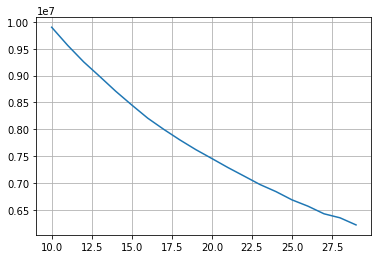

In [23]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#pca = 6
# sum of distance
n=len(df_scaled_pca)
aver_dist=[-1*i for i in sum_dist]
plt.plot(range(10, 30),aver_dist)
plt.grid(True)

Text(0.5,1,'Average Distance by Number of clusters')

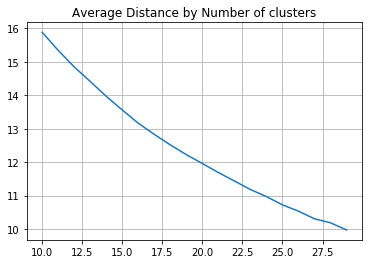

In [42]:
#pca = 6
#average distance
n=len(df_scaled_pca)
aver_dist=[-1*i/n for i in sum_dist]
plt.plot(range(10, 30),aver_dist)
plt.grid(True)
plt.title("Average Distance by Number of clusters")

Text(0.5,1,'Net Change in Average Distance by Number of clusters')

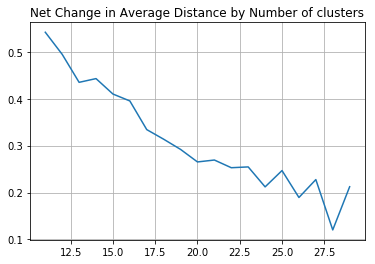

In [40]:
# Calculate net effect
aver_dist_6=[15.88459631550095,
 15.342871182534394,
 14.848300328597542,
 14.413385855166451,
 13.97050327729038,
 13.560512487474554,
 13.165286324672381,
 12.831160643327479,
 12.517537328953466,
 12.225628970756707,
 11.960452765419221,
 11.691208037774553,
 11.43836086703286,
 11.183798996318469,
 10.971791121503593,
 10.725001390650451,
 10.535628204502569,
 10.308042341901674,
 10.187816573277498]

aver_dist_6_lag=[
 15.342871182534394,
 14.848300328597542,
 14.413385855166451,
 13.97050327729038,
 13.560512487474554,
 13.165286324672381,
 12.831160643327479,
 12.517537328953466,
 12.225628970756707,
 11.960452765419221,
 11.691208037774553,
 11.43836086703286,
 11.183798996318469,
 10.971791121503593,
 10.725001390650451,
 10.535628204502569,
 10.308042341901674,
 10.187816573277498,
 9.975521390329872]

diff=[a-b for (a,b) in zip(aver_dist_6, aver_dist_6_lag)]
plt.plot(range(11, 30), diff)
plt.grid(True)
plt.title("Net Change in Average Distance by Number of clusters")


In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
kmeans_final = KMeans(n_clusters=20)
kmeans_final.fit(df_scaled_pca)
kmeans_demo_label=kmeans_final.labels_


In [59]:
kmeans_demo_label.shape

(623209,)

### Discussion 3.1: Apply Clustering to General Population


When plotting sum/average distances from the data points to its cluster centroid, at 20 clusters, the distances seem decreasing at decreasing rate. To be clear, net change of the average distance is plotted over different numbers of clusters. From the graph, starging from cluster numner of 20, the dicrease in net change is reduced clearly and very volatile. Thus, 20 is selected for final number of clusters to group the data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')#, dtype={'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015': object})\

In [61]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_c=clean_data(customers)
df_c.fillna(0, inplace=True) # fill NA in customers with zero
# Apply feature scaling to the general population demographics data.
df_scaled_c=scaler.transform(df_c)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
# Apply PCA to the data.
df_scaled_pca_c=pca.transform(df_scaled_c)
print(df_scaled_pca_c.shape) 


(115643, 6)


In [63]:
# Apply PCA to the data.
kmeans_demo_label_c=kmeans_final.predict(df_scaled_pca_c)
kmeans_demo_label_c.shape #customer label

(115643,)

In [64]:
#population label
kmeans_demo_label.shape

(623209,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [65]:
# creat proportion in each cluster for custormer
from collections import Counter
count_c = Counter(kmeans_demo_label_c)
df_count_c=pd.DataFrame.from_dict(data=count_c, orient='index', dtype=None)
df_count_c['count_c']=df_count_c[0]
df_count_c['portion_c']=df_count_c['count_c']/len(kmeans_demo_label_c)
df_count_c

,0,count_c,portion_c
13,35521,35521,0.307161
1,12389,12389,0.107131
3,10372,10372,0.089690
6,16197,16197,0.140060
17,7144,7144,0.061776
10,2805,2805,0.024256
2,658,658,0.005690
19,4769,4769,0.041239
18,9401,9401,0.081293
8,4925,4925,0.042588


In [66]:
# creat proportion in each cluster for population data
count = Counter(kmeans_demo_label)
df_count=pd.DataFrame.from_dict(data=count, orient='index', dtype=None)
df_count['count']=df_count[0]
df_count['portion']=df_count['count']/len(kmeans_demo_label)
df_count

,0,count,portion
16,38818,38818,0.062287
5,28524,28524,0.045770
3,57216,57216,0.091809
7,29743,29743,0.047726
13,41304,41304,0.066276
15,23302,23302,0.037390
17,31925,31925,0.051227
18,41428,41428,0.066475
10,22021,22021,0.035335
4,34297,34297,0.055033


In [67]:
counts = pd.concat([df_count_c, df_count], axis=1)
portions=counts[['portion','portion_c']]
portions.sort_values(by=['portion_c'], ascending=False, inplace=True)
portions

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,portion,portion_c
13,0.066276,0.307161
6,0.045232,0.140060
1,0.054202,0.107131
3,0.091809,0.089690
18,0.066475,0.081293
17,0.051227,0.061776
8,0.041265,0.042588
19,0.061036,0.041239
10,0.035335,0.024256
4,0.055033,0.022630


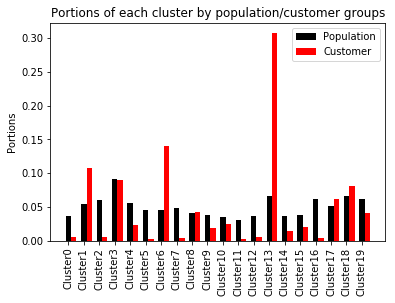

In [68]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure()
ax = fig.add_subplot(111)


## necessary variables
              # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(portions.index, portions.portion, width,
                color='black')

rects2 = ax.bar(portions.index+width, portions.portion_c, width,
                    color='red')



ax.set_ylabel('Portions')
ax.set_title('Portions of each cluster by population/customer groups')
xTickMarks = ['Cluster'+str(i) for i in portions.index]
ax.set_xticks(portions.index)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Population', 'Customer') )

plt.show()

In [69]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
#portions.portion_c>portions.portion
print('Clusters are overrepresented in the customer dataset is: \n', portions[portions.portion_c>portions.portion])

Clusters are overrepresented in the customer dataset is: 
      portion  portion_c
13  0.066276   0.307161
6   0.045232   0.140060
1   0.054202   0.107131
18  0.066475   0.081293
17  0.051227   0.061776
8   0.041265   0.042588


In [70]:
#customers at cluster = 13
cust=df_scaled_pca_c[kmeans_demo_label_c==13]
df_scaled_cust=pca.inverse_transform(cust)
df_cust=scaler.inverse_transform(df_scaled_cust)

#population at cluster = 13
pop=df_scaled_pca[kmeans_demo_label==13]
df_scaled_pop=pca.inverse_transform(pop)
df_pop=scaler.inverse_transform(df_scaled_pop)

#create data frame with the difference of values between two groups are biggest
diff=df_cust.mean(axis=0)-df_pop.mean(axis=0)
df_diff = pd.DataFrame( diff, index=df_c.columns)
df_diff.sort_values(by=[0])

,0
KBA13_ANZAHL_PKW,-2.763623
SEMIO_VERT,-0.459728
SEMIO_FAM,-0.458197
SEMIO_KULT,-0.431042
SEMIO_SOZ,-0.406441
W_KEIT_KIND_HH,-0.322309
SEMIO_REL,-0.299729
PRAEGENDE_JUGENDJAHRE_gen,-0.294194
SEMIO_MAT,-0.277040
ORTSGR_KLS9,-0.154632


In [71]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#portions.portion_c<portions.portion
print('Clusters are overrepresented in the customer dataset is: \n', portions[portions.portion_c<portions.portion])

Clusters are overrepresented in the customer dataset is: 
      portion  portion_c
3   0.091809   0.089690
19  0.061036   0.041239
10  0.035335   0.024256
4   0.055033   0.022630
15  0.037390   0.020529
9   0.038315   0.018531
14  0.036947   0.013983
0   0.036715   0.005725
2   0.059879   0.005690
12  0.036654   0.004920
7   0.047726   0.004159
16  0.062287   0.003762
5   0.045770   0.002784
11  0.030428   0.002093


In [72]:
#customers at cluster = 16
cust=df_scaled_pca_c[kmeans_demo_label_c==16]
df_scaled_cust=pca.inverse_transform(cust)
df_cust=scaler.inverse_transform(df_scaled_cust)

#population at cluster = 16
pop=df_scaled_pca[kmeans_demo_label==16]
df_scaled_pop=pca.inverse_transform(pop)
df_pop=scaler.inverse_transform(df_scaled_pop)

#create data frame with the difference of values between two groups are biggest
diff=df_cust.mean(axis=0)-df_pop.mean(axis=0)
df_diff = pd.DataFrame( diff, index=df_c.columns)
df_diff.sort_values(by=[0])

,0
KBA13_ANZAHL_PKW,-29.478379
PRAEGENDE_JUGENDJAHRE_gen,-4.129385
FINANZ_ANLEGER,-0.672590
SEMIO_RAT,-0.605508
SEMIO_KAEM,-0.566233
SEMIO_PFLICHT,-0.516851
HH_EINKOMMEN_SCORE,-0.503026
BALLRAUM,-0.502643
SEMIO_KRIT,-0.484363
INNENSTADT,-0.481605


# Discussion 3.3: Compare Customer Data to Demographics Data

From investigating difference of variables between two groups in 'cluster 13', following analyzing results were drived.
Variables have smaller values for customers groups:

KBA13_ANZAHL_PKW (Number of cars in the PLZ8 region): Number of cars in the PLZ8 region 

SEMIO_VERT (1: highest affinity) dreamful 

SEMIO_FAM (1: highest affinity) family-minded 

SEMIO_KULT (1: highest affinity) cultural-minded 

Values are larger for customers groups:

LP_FAMILIE_GROB (Family type, rough scale 5: multiperson household)

SEMIO_DOM (1: highest affinity) :dominant-minded 

SEMIO_ERL (1: highest affinity) : event-oriented

SEMIO_KAEM (1: highest affinity) : combative attitude 


Hence from cluster 13 results, the customer groups have key words of small number of cars in the PLZ8 region, dreamful, family-minded, cultural-minded, not dominant-minded, not combative attitude, not event-oriented.

From investigating difference of variables between two groups in 'cluster 16', following analyzing results were drived.
Variables have smaller values for customers groups:

KBA13_ANZAHL_PKW (Number of cars in the PLZ8 region): Number of cars in the PLZ8 region 

PRAEGENDE_JUGENDJAHRE_gen: (Dominating movement of person's youth 1: 40s): old

FINANZ_ANLEGER: investor (1: very high)

SEMIO_RAT :rational (1: highest affinity)

SEMIO_KAEM : combative attitude (1: highest affinity)


Values are larger for customers groups:


SEMIO_VERT:dreamful (1: highest affinity)

ORTSGR_KLS9 ( Size of community, 9: > 700,000  inhabitants) 

FINANZ_MINIMALIST (low financial interest, 1: very high)	

SEMIO_SOZ (socially-minded, 1: highest affinity)


Hence from cluster 16 results, the customer groups have key words of small number of cars in the PLZ8 region, old, investor, rational, combative, not dreamful, big community with many inhabitants, high financial interest, not socially-minded.

From the two cluster analyzing results, two potential groups of customers with the mail-order company, are identified. first one with more cultural family minded groups and second one with financially interested group.